# CIFAR-10 CNN Classifier - Comprehensive Evaluation

## 1. Import Required Libraries

In [5]:
import torch
import torchvision
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import random
import os

## 3. CNN Model Definition

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## 4. Data Loading and Transformation

In [7]:
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms


# --------------------------- Load CIFAR10 -------------------------- #
def load_CIFAR10(batch_size=64):
    # ---------------- Parameters ---------------- #

    num_workers = 0

    # Transform credit to https://sidthoviti.com/fine-tuning-resnet50-pretrained-on-imagenet-for-cifar-10/
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    # ---------------- Transforms ---------------- #
    transform_train =transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean,std),
        ]
    )

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

    # --------- Load full dataset without transforms ---------- #
    train_val_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

    # --------- Split indices for train and val ---------- #
    train_size = int(0.8 * len(train_val_dataset))
    val_size = len(train_val_dataset) - train_size
    train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

    # --------- Manually assign transforms --------- #
    train_dataset.dataset.transform = transform_train  # affects only Subset view
    val_dataset.dataset.transform = transform_train

    # --------- DataLoaders --------- #
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # --------- Test set --------- #
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_CIFAR10(batch_size=64)
classes = test_loader.dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


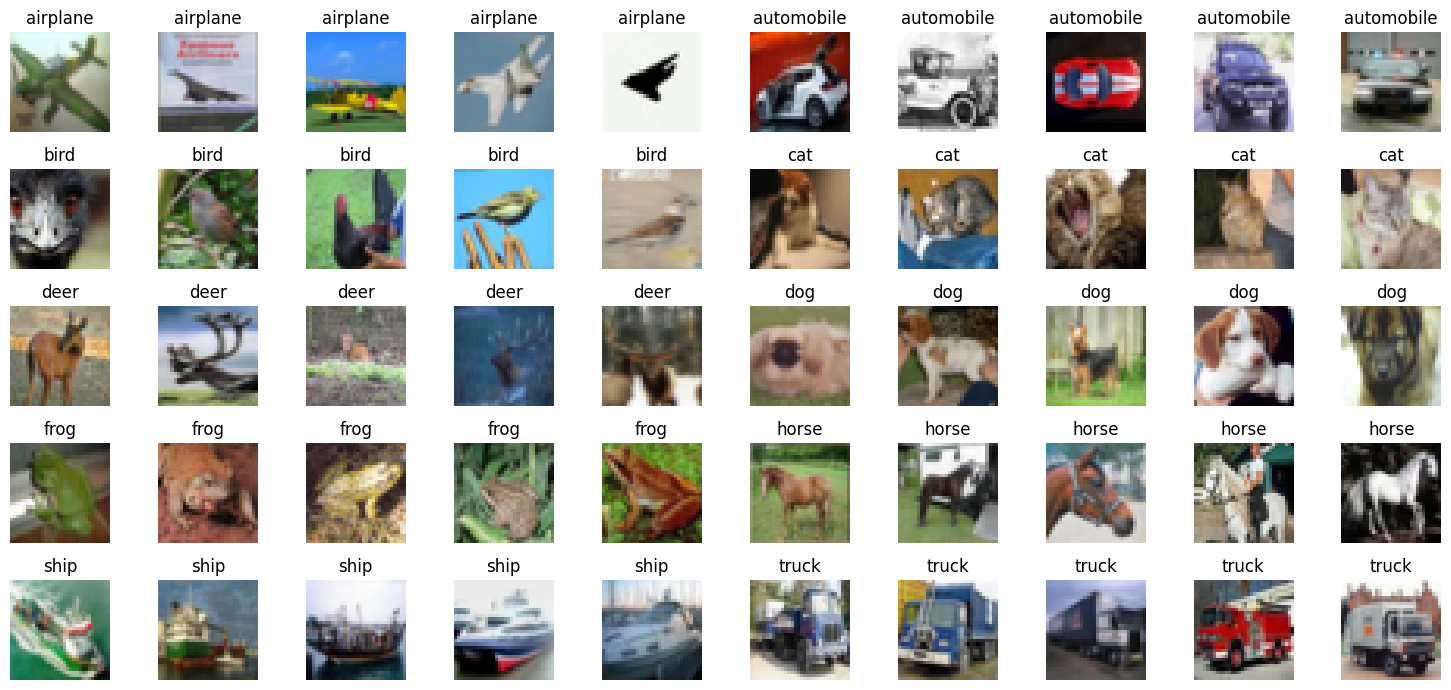

In [8]:
# Unnormalize tensor to image
def unormalize_image(img_tensor, mean, std):
    img = img_tensor.clone().cpu()  # clone to avoid modifying original
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]  # unnormalize each channel
    img = torch.clamp(img, 0, 1)  # ensure values are in [0,1] range
    return img.permute(1, 2, 0).numpy()

# Visualize the the 10 classes in the dataset with 5 images each
train_dataset = test_loader.dataset
classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
class_indices = {class_name: [] for class_name in classes}
for idx, (image, label) in enumerate(train_dataset):
    class_name = classes[label]
    if len(class_indices[class_name]) < 5:
        class_indices[class_name].append(idx)
# Randomly select 5 images from each class
selected_indices = []
for class_name, indices in class_indices.items():
    selected_indices.extend(random.sample(indices, 5))
# Plot the images
fig, axes = plt.subplots(5, 10, figsize=(15, 7))
for i, idx in enumerate(selected_indices):
    image, label = train_dataset[idx]
    image = unormalize_image(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ax = axes[i // 10, i % 10]
    ax.imshow(image)
    ax.set_title(classes[label])
    ax.axis("off")
plt.tight_layout()
plt.show()

## 5. Model Training

In [9]:
def load_checkpoint(path, model, optimizer=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return (checkpoint['epoch'],
            checkpoint['train_losses'],
            checkpoint['train_accs'],
            checkpoint['val_accs'])

In [6]:
train_model = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 200

train_losses = []
train_accuracies = []
val_accs = []

resume_training = False  # or False to start fresh
resume_path = "resnet152_epoch78.pth"  # last saved file
if resume_training:
    start_epoch, train_losses, train_accs, val_accs, best_accuracy = load_checkpoint(
        resume_path, model, optimizer)
    print(f"Resuming from epoch {start_epoch+1}")
else:
    start_epoch = 0
    train_losses = []
    train_accs = []
    val_accs = []
    best_accuracy = 0.0

best_accuracy = 0.0
if train_model:
    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            
        # Validation loop
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
    
        epoch_val_acc = 100.0 * val_correct / val_total
    
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        val_accs.append(epoch_val_acc)
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'train_accs': train_accuracies,
        'val_accs': val_accs,
    }, "simple_cnn_epoch"+str(epoch)+".pth")
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Val Accuracy: {epoch_val_acc:.2f}%")


## 6. Model Evaluation

### Load model

In [10]:
# Model path
model_path = "Simple_CNN_model.pth"

# Folder path
folder_path = "SimpleCNN_metrics"

In [11]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=10).to(device)
start_epoch, train_losses, train_accs, val_accs = load_checkpoint(
        model_path, model)

# Make folder
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

### Training history plots

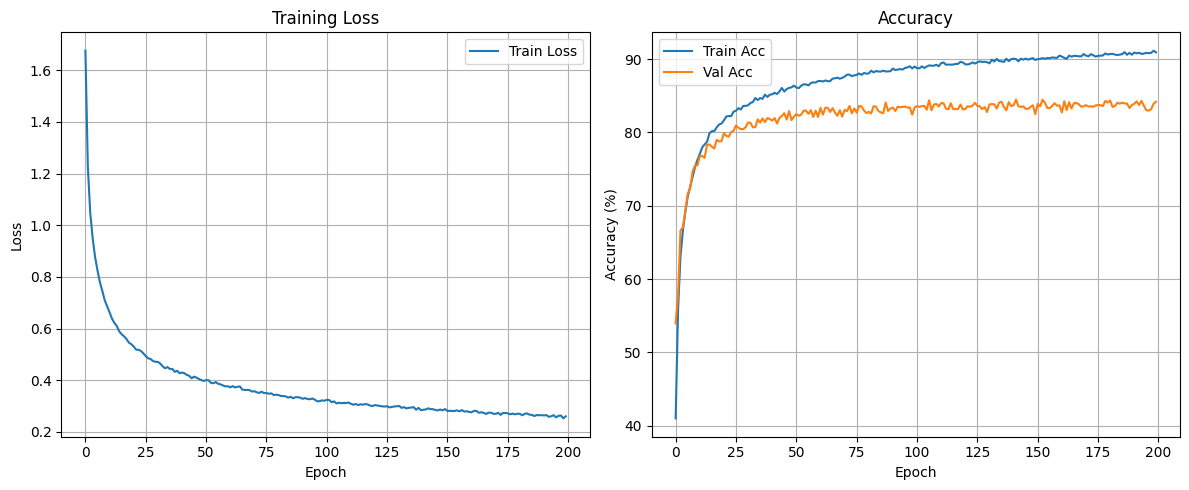

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(folder_path + "/loss_accuracy.png")
plt.show()

### Accuracy

In [13]:
model.eval()
test_correct = 0
test_total = 0
test_preds = []
test_labels = []
y_score = []
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_score.extend(outputs.cpu().numpy())
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        
# Compute accuracy
test_accuracy = 100.0 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 157/157 [00:08<00:00, 19.59it/s]

Test Accuracy: 84.82%


### Classification report

In [14]:
model.eval()

# Classification Report
report = classification_report(test_labels, test_preds, target_names=classes)
print(report)
# Save classification report to a text file
with open(folder_path + "/classification_report.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

    airplane       0.84      0.85      0.85      1000
  automobile       0.91      0.94      0.92      1000
        bird       0.77      0.82      0.80      1000
         cat       0.73      0.69      0.71      1000
        deer       0.86      0.82      0.84      1000
         dog       0.74      0.82      0.78      1000
        frog       0.93      0.86      0.89      1000
       horse       0.91      0.87      0.89      1000
        ship       0.90      0.92      0.91      1000
       truck       0.90      0.89      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## 7. Confusion Matrix Visualization

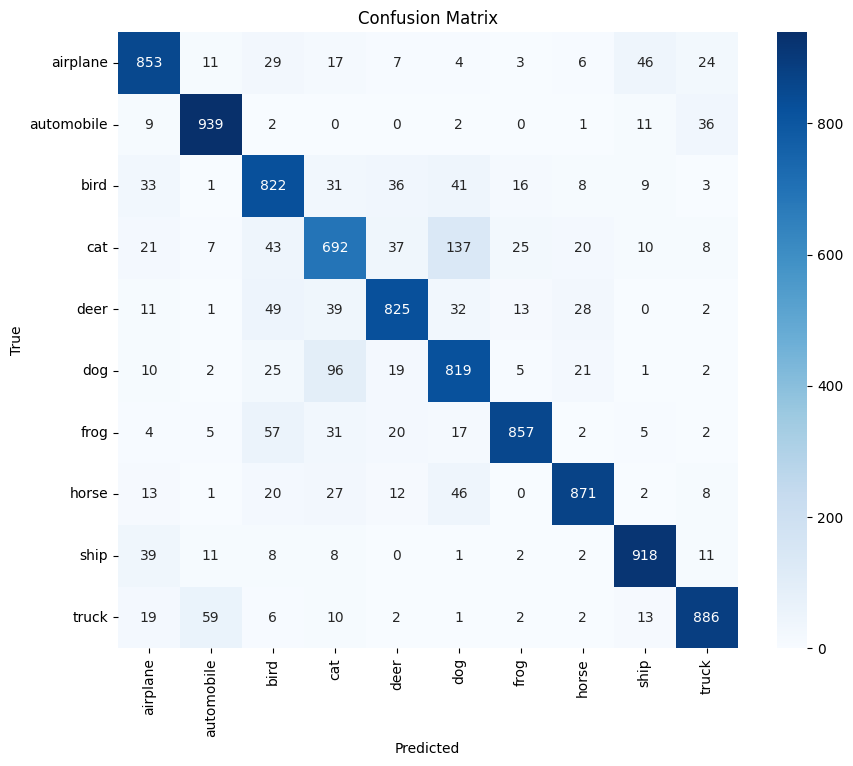

In [15]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(folder_path + "/confusion_matrix.png")
plt.show()

### ROC Curve

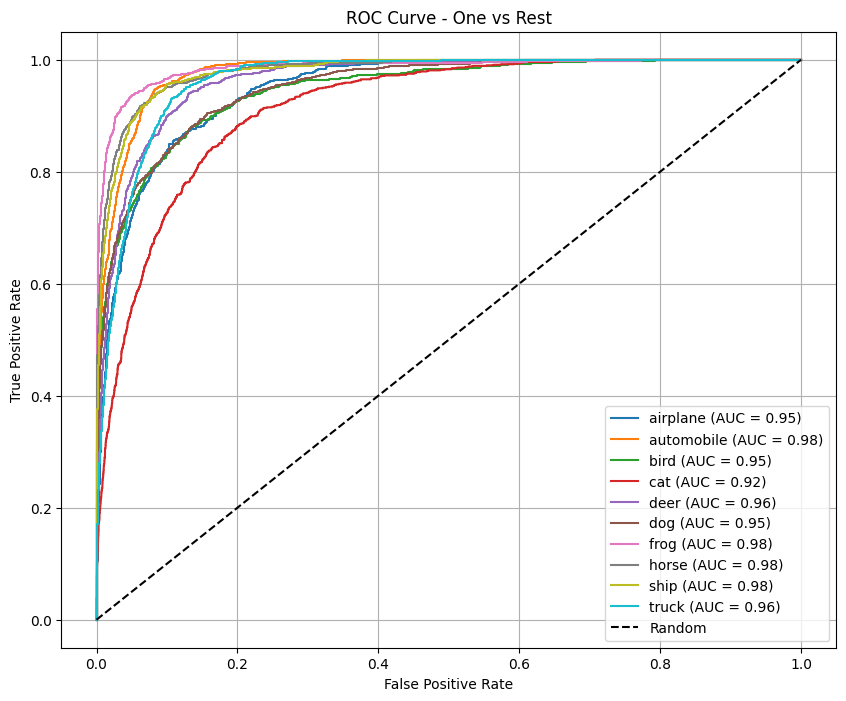

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarize labels
n_classes = len(classes)
y_true = label_binarize(test_labels, classes=list(range(n_classes)))
y_score = np.array(y_score)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve - One vs Rest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig(folder_path + "/ROC Curve - One vs Rest.png")
plt.show()

# Other:

In [ ]:
def plot_metric_bar(metrics_df, metric_name):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=metrics_df.index, y=metric_name, data=metrics_df)
    plt.title(f'{metric_name} per Class')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    for i, v in enumerate(metrics_df[metric_name]):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    plt.show()


## 9. Precision Visualization

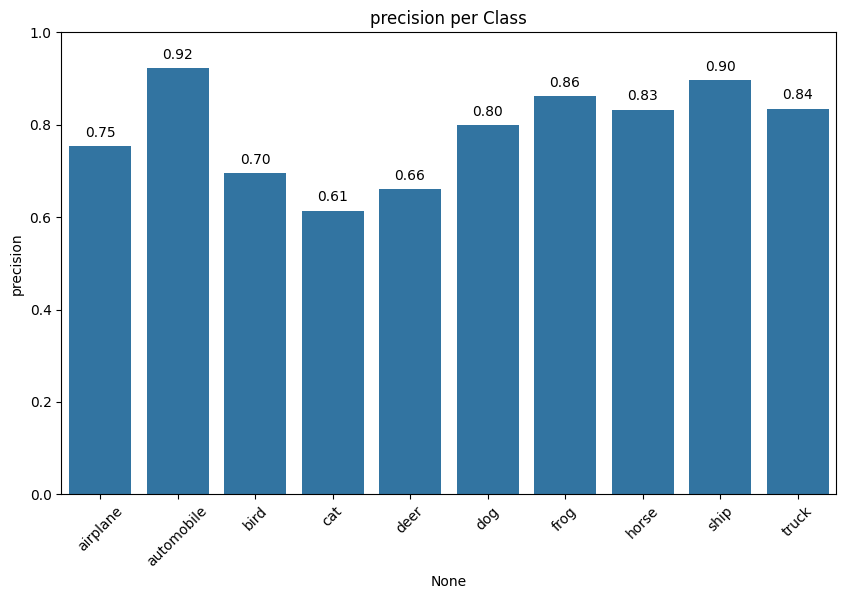

In [ ]:
plot_metric_bar(metrics_df, 'precision')

## 10. Recall (Sensitivity) Visualization

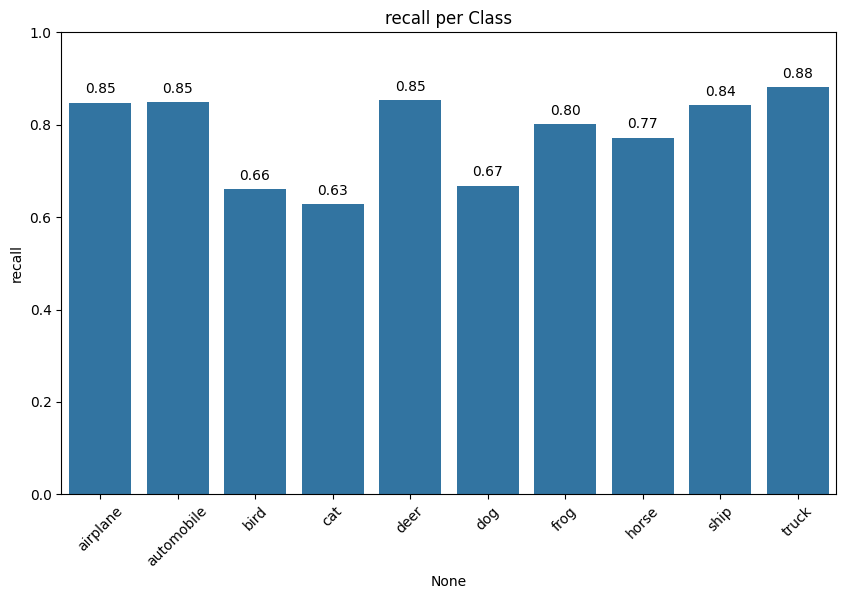

In [ ]:
plot_metric_bar(metrics_df, 'recall')

## 11. F1-Score Visualization

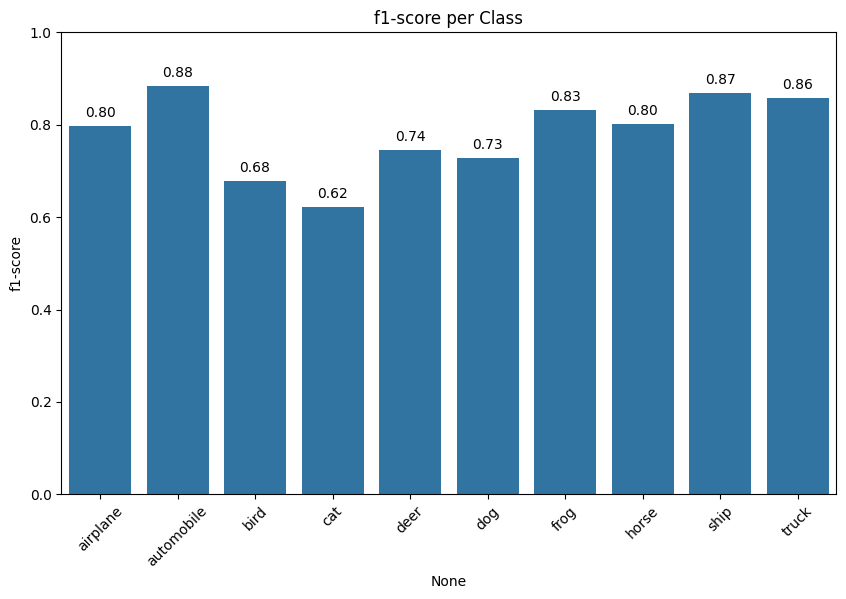

In [ ]:
plot_metric_bar(metrics_df, 'f1-score')

## 12. Support Visualization

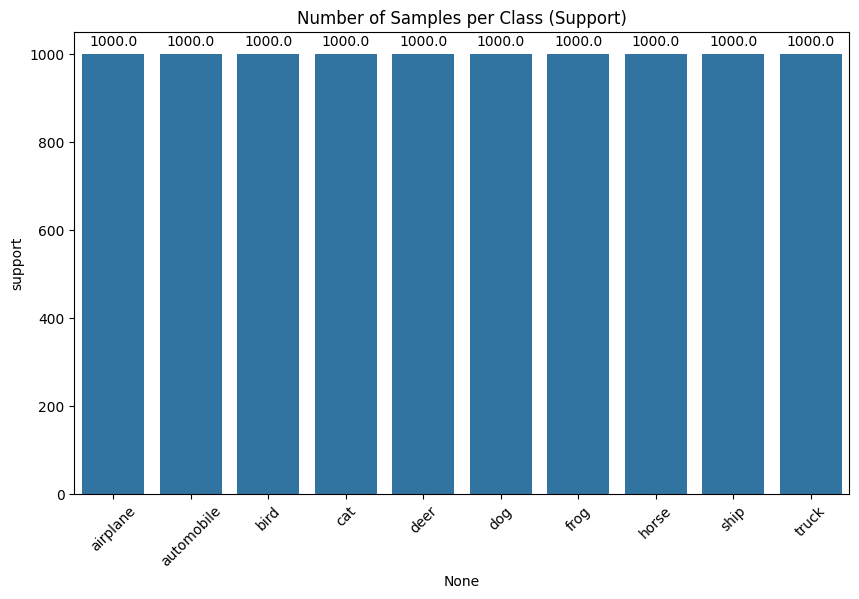

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_df.index, y='support', data=metrics_df)
plt.title('Number of Samples per Class (Support)')
plt.xticks(rotation=45)
for i, v in enumerate(metrics_df['support']):
    plt.text(i, v + 20, str(v), ha='center')
plt.show()